In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [11]:
training = [
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40000.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40007.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40001.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40009.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/original/40019.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3996.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3991.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3959.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3939.png',
    'https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/img_3933.png'
]

labels = [
    0, 0, 1, 1, 0, 0, 1, 0, 1, 1
]

In [12]:
skin_fn = lambda x: "Lighter" if x == 1 else "Darker"
labels = list(map(skin_fn, labels))

In [13]:
hints = [f"This face has a {skin} skin." for skin in labels]

In [16]:
skin_training = pd.read_csv('fairness/training.tsv', sep='\t').iloc[0:0]

In [17]:
skin_training['INPUT:image'] = training
skin_training['GOLDEN:result'] = labels
skin_training['HINT:text'] = hints

In [20]:
skin_training.to_csv('fairness/training.tsv', sep='\t', index=None)

In [24]:
cols = ['INPUT:image']
org = pd.read_csv('org_label.csv')[cols]
fake = pd.read_csv('fake_label.csv')[cols]

In [34]:
sampled = pd.concat((org[:100], fake[:100]))

In [36]:
sampled.to_csv('fairness/sampled.tsv', sep='\t', index=None)

In [37]:
rest = pd.concat((org[100:], fake[100:]))

In [40]:
rest.to_csv('fairness/rest.tsv', sep='\t', index=None)

## Analysis

In [101]:
link2id = lambda x: x.split('/')[-1].split('"')[0]

In [102]:
res = pd.read_csv('fairness/results/assignments_from_pool_33873013__13-06-2022.tsv', sep='\t')

In [103]:
res = res[::2][['INPUT:image', 'OUTPUT:result']]

In [104]:
res['result'] = res['OUTPUT:result'].apply(lambda x: 1 if x == 'Darker' else 0)

In [105]:
res = res.groupby('INPUT:image').sum()

In [106]:
from copy import deepcopy
final_res = deepcopy(res)
final_res['skin'] = final_res['result'].apply(lambda x: 1 if x >= 2 else 0)
final_res = final_res.drop(['result'], axis=1)

In [107]:
final_res = final_res.reset_index()

In [108]:
final_res['INPUT:image'] = final_res['INPUT:image'].apply(link2id)

In [109]:
sum(final_res['skin']) / len(final_res)

0.089

In [110]:
org_imgs_acc = pd.read_csv('org_imgs_worker_acc.csv')
fake_imgs_acc = pd.read_csv('fake_imgs_worker_acc.csv')

In [111]:
img_acc = pd.concat((org_imgs_acc, fake_imgs_acc))

In [112]:
skin_acc = final_res.merge(img_acc, on='INPUT:image')

In [113]:
skin_acc

,INPUT:image,skin,n_workers,acc
0,img_1.png,1,3.0,0.666667
1,img_101.png,0,2.0,0.000000
2,img_103.png,0,2.0,1.000000
3,img_105.png,0,4.0,0.750000
4,img_107.png,0,5.0,0.800000
...,...,...,...,...
995,40996.png,0,4.0,0.750000
996,40997.png,0,4.0,1.000000
997,40998.png,0,4.0,1.000000
998,40999.png,0,4.0,0.750000


In [72]:
def freq_bar(real_y, fake_y, title):
    skin_list = ['Lighter', 'Darker']

    fig, ax = plt.subplots()
    x = np.arange(len(skin_list))
    width = 0.35

    p1 = ax.bar(x - width/2, real_y, width, label='Real')
    p2 = ax.bar(x + width/2, fake_y, width, label='Fake')
    ax.bar_label(p1)
    ax.bar_label(p2)

    ax.set_title(title)

    ax.set_xticks(x)
    ax.set_xticklabels(skin_list)

    ax.legend(loc='lower left')
    return fig

In [120]:
skin_acc[500:].groupby('skin').mean()

,n_workers,acc
skin,,
0,3.663636,0.821591
1,3.566667,0.843611


In [119]:
skin_acc[:500].groupby('skin').mean()

,n_workers,acc
skin,,
0,3.511677,0.672435
1,3.827586,0.773563


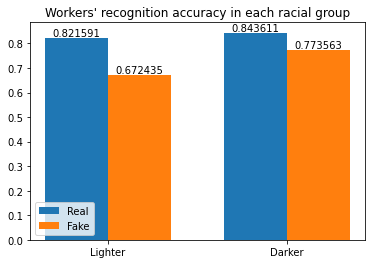

In [128]:
fig = freq_bar(
    skin_acc[500:].groupby('skin').mean()['acc'],
    skin_acc[:500].groupby('skin').mean()['acc'],
    "Workers' recognition accuracy in each racial group"
)

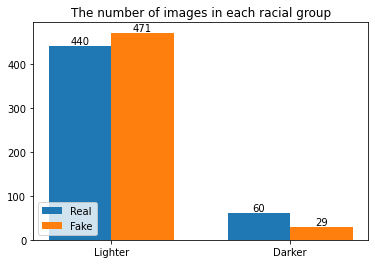

In [129]:
fig = freq_bar(
    skin_acc[500:]['skin'].value_counts().sort_index(),
    skin_acc[:500]['skin'].value_counts().sort_index(),
    "The number of images in each racial group"
)

## Create Balenced Skin Pool

`0` indicates lighter skin, and `1` indicates darker skin.

In [2]:
true_imgs = pd.read_csv('true_img.csv', header=None, names=['INPUT:image', 'skin'])
fake_imgs = pd.read_csv('fake_skin.csv').dropna().astype({'skin': int})
fake_imgs['INPUT:image'] = fake_imgs['INPUT:image'].apply(
    lambda x: f"https://raw.githubusercontent.com/BirkhoffG/crowd_project/main/img/{x}")

In [3]:
true_imgs_lighter = true_imgs[true_imgs['skin'] == 0]
true_imgs_darker = true_imgs[true_imgs['skin'] == 1]

In [4]:
fake_imgs_lighter = fake_imgs[fake_imgs['skin'] == 0]
fake_imgs_darker = fake_imgs[fake_imgs['skin'] == 1]

In [26]:
balanced_set_control = pd.concat((
    true_imgs_lighter[:50], true_imgs_darker[:50],
    fake_imgs_lighter[:50], fake_imgs_darker[:50],
))

balanced_set_general = pd.concat((
    true_imgs_lighter[50:100], true_imgs_darker[50:100],
    fake_imgs_lighter[50:100], fake_imgs_darker[50:100],
))

In [28]:
balanced_set = pd.concat((
    true_imgs_lighter[:100], true_imgs_darker[:100],
    fake_imgs_lighter[:100], fake_imgs_darker[:100],
))

In [29]:
control_task = pd.read_csv("tasks_for_pool_33923754__15-06-2022.tsv", sep='\t')[:0]

In [30]:
control_task['INPUT:image'] = balanced_set['INPUT:image']
control_task['GOLDEN:result'] = [0] * 200 + [1] * 200 

In [31]:
control_task[['INPUT:image', 'GOLDEN:result']].to_csv('control_tasks.tsv', index=None, sep='\t')

### Analysis

In [27]:
# control_task[['INPUT:image', 'GOLDEN:result']].to_csv('control_tasks.tsv', index=None, sep='\t')
balanced_set_general[['INPUT:image']].to_csv('general_tasks.tsv', index=None, sep='\t')

In [54]:
worker_acc = pd.read_csv('fairness/fake_real_worker_acc/assignments_from_pool_33923754__15-06-2022.tsv',
    sep='\t').dropna(axis=0, how='all')
worker_acc['INPUT:image'] = worker_acc['INPUT:image'].apply(lambda x: x.replace('"', ''))

In [55]:
worker_final_acc = worker_acc[['INPUT:image', 'OUTPUT:result', 'GOLDEN:result']].groupby('INPUT:image').sum().reset_index()

In [57]:
worker_final_acc = worker_final_acc.merge(balanced_set, on='INPUT:image')

In [60]:
worker_final_acc_real = worker_final_acc[worker_final_acc['GOLDEN:result'] == 0.]
worker_final_acc_fake = worker_final_acc[worker_final_acc['GOLDEN:result'] > 0]

In [69]:
worker_final_acc_fake['acc'] = worker_final_acc_fake['OUTPUT:result'] / worker_final_acc_fake['GOLDEN:result']
worker_final_acc_real['acc'] = (3 - worker_final_acc_real['OUTPUT:result']) / (3 - worker_final_acc_real['GOLDEN:result'])

<ipython-input-69-955dbf0200bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_final_acc_fake['acc'] = worker_final_acc_fake['OUTPUT:result'] / worker_final_acc_fake['GOLDEN:result']
<ipython-input-69-955dbf0200bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  worker_final_acc_real['acc'] = (3 - worker_final_acc_real['OUTPUT:result']) / (3 - worker_final_acc_real['GOLDEN:result'])


In [70]:
worker_final_acc_fake['acc'].mean()

0.5666666666666665

In [71]:
worker_final_acc_real['acc'].mean()

0.7066666666666666

In [73]:
worker_final_acc_real

,INPUT:image,OUTPUT:result,GOLDEN:result,skin,acc
200,https://raw.githubusercontent.com/BirkhoffG/cr...,0.0,0.0,0,1.000000
201,https://raw.githubusercontent.com/BirkhoffG/cr...,1.0,0.0,0,0.666667
202,https://raw.githubusercontent.com/BirkhoffG/cr...,1.0,0.0,1,0.666667
203,https://raw.githubusercontent.com/BirkhoffG/cr...,2.0,0.0,0,0.333333
204,https://raw.githubusercontent.com/BirkhoffG/cr...,3.0,0.0,0,0.000000
...,...,...,...,...,...
395,https://raw.githubusercontent.com/BirkhoffG/cr...,1.0,0.0,1,0.666667
396,https://raw.githubusercontent.com/BirkhoffG/cr...,1.0,0.0,1,0.666667
397,https://raw.githubusercontent.com/BirkhoffG/cr...,0.0,0.0,1,1.000000
398,https://raw.githubusercontent.com/BirkhoffG/cr...,1.0,0.0,1,0.666667


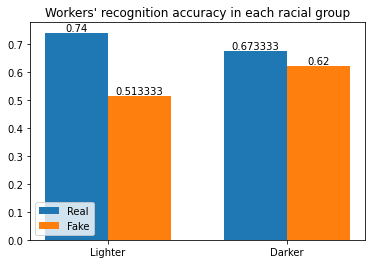

In [74]:
fig = freq_bar(
    real_y=worker_final_acc_real.groupby('skin').mean()['acc'],
    fake_y=worker_final_acc_fake.groupby('skin').mean()['acc'],
    # skin_acc[500:].groupby('skin').mean()['acc'],
    # skin_acc[:500].groupby('skin').mean()['acc'],
    title="Workers' recognition accuracy in each racial group"
)